<a href="https://www.kaggle.com/code/inkpansuwan/rice-classification-using-mobilenetv2?scriptVersionId=181462737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Steps:** 
    
    1)  Import libraries.

    2)  Load data (and split into training & validation sets).

    2.5)  Plot some images to see what the data looks like.

    3) Set up a pre-train base of choice: MobileNetV2.

    4) Attach extra layers to the base.

    5) Train the model.

    6) Create confusion matrix & classification performance.

    7) Inspect correct and incorrect classification.


**To improve on later:** 

    1) Create a test set & evaluate performance on test set (Step 2, 6, 7)
    2) Find a way to extract performance from training better.
    3) Compare with different pre-trained base, other model configurations.

### 1) Import libraries

In [2]:
# import basic libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

# import tensorflow  
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import data

from sklearn.metrics import confusion_matrix, classification_report

# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.layers.experimental import preprocessing

# Plotting 
import matplotlib.pyplot as plt

2024-06-04 12:36:50.173195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:36:50.173316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:36:50.354474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2) Load data

In [3]:
# set path to data directory
path = Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

# check files in the directory
list(path.glob('*'))

[PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Rice_Citation_Request.txt'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Arborio'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala')]

In [4]:
# Set parameters
IMAGE_SIZE=(224, 224)
BATCH_SIZE=32


# Create training and validation sets
orig_data = keras.preprocessing.image_dataset_from_directory(directory=path,
                                                        labels='inferred',
                                                        label_mode ='categorical',
                                                        image_size=IMAGE_SIZE,
                                                        subset='both',
                                                        batch_size=BATCH_SIZE,
                                                        validation_split=0.2,
                                                        shuffle=True,
                                                        seed=42)

train_dataset = orig_data[0]
validation_dataset = orig_data[1]

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Using 15000 files for validation.


In [5]:
# Check number of batches
print('Number of training batches: %d' % data.experimental.cardinality(train_dataset))
print('Number of validation  batches: %d' % data.experimental.cardinality(validation_dataset))

Number of training batches: 1875
Number of validation  batches: 469


In [6]:
# Check class distribution


### 2.5) Plot some images

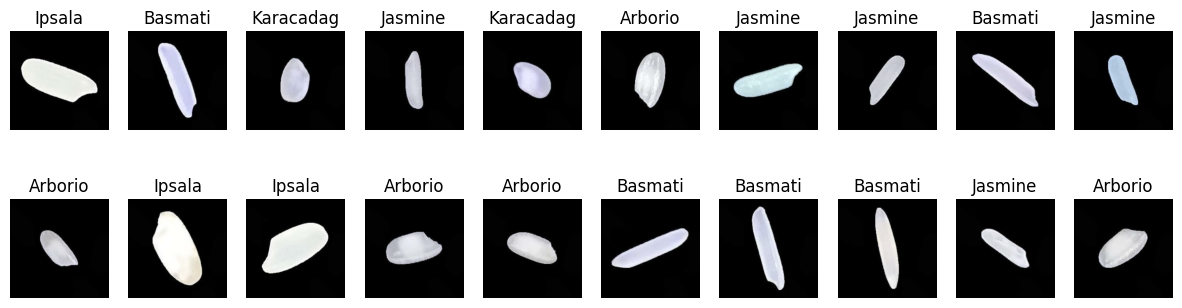

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 4))
for images, labels in train_dataset.take(1): # take data from batch 1 (32 items)
    for i in range(20):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ind = np.where(labels[i] == 1)[0][0]
        plt.title(class_names[ind])
#         plt.title(class_names[labels[i]])
        plt.axis("off")

### 3) Set up a pre-trained base

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMAGE_SHAPE = IMAGE_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Check features extracted from the base
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [10]:
# set trainable to False
base_model.trainable = False

# Check the structure of the base model
# base_model.summary()


In [11]:
# # Add global average pooling layer 
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(base_model.output)

print(feature_batch_average.shape)


# Add prediction later
prediction_layer = keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(None, 1280)
(None, 5)


### 4) Attach extra layers to the base

In [12]:
# Putting all the layers together
model = keras.Sequential([base_model,
                          global_average_layer,
                          prediction_layer
])

In [13]:
model.summary(line_length=100)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)          │ ?                               │         2,257,984 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ global_average_pooling2d                   │ (None, 1280)                    │                 0 │
│ (GlobalAveragePooling2D)                   │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense (Dense)                              │ (None, 5)                       │             6,405 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 5) Train the model

In [14]:
optimizer = keras.optimizers.Adam(epsilon=0.0001)
model.compile(
    optimizer=optimizer,
    loss = "categorical_crossentropy",
    metrics=['accuracy'],
)

In [15]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
   3/1875 ━━━━━━━━━━━━━━━━━━━━ 1:13 39ms/step - accuracy: 0.2083 - loss: 2.1962  

I0000 00:00:1717504704.222346      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717504704.251842      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8977 - loss: 0.3044

W0000 00:00:1717504795.856568      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 63ms/step - accuracy: 0.8977 - loss: 0.3044 - val_accuracy: 0.9679 - val_loss: 0.0911
Epoch 2/10


W0000 00:00:1717504823.043894      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9717 - loss: 0.0827 - val_accuracy: 0.9775 - val_loss: 0.0644
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9765 - loss: 0.0690 - val_accuracy: 0.9763 - val_loss: 0.0686
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9791 - loss: 0.0612 - val_accuracy: 0.9748 - val_loss: 0.0714
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9804 - loss: 0.0568 - val_accuracy: 0.9802 - val_loss: 0.0571
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9818 - loss: 0.0536 - val_accuracy: 0.9801 - val_loss: 0.0560
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9820 - loss: 0.0510 - val_accuracy: 0.9821 - val_loss: 0.0505
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9829 - loss: 0.0488 - val_accuracy: 0.9811 - val_loss: 0.0539
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9824 - loss: 0.04

In [16]:
# Evaluate on validation dataset (should ideally be independent test set)
# loss0, accuracy0 = model.evaluate(validation_dataset)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [17]:
# Check on possible keys
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


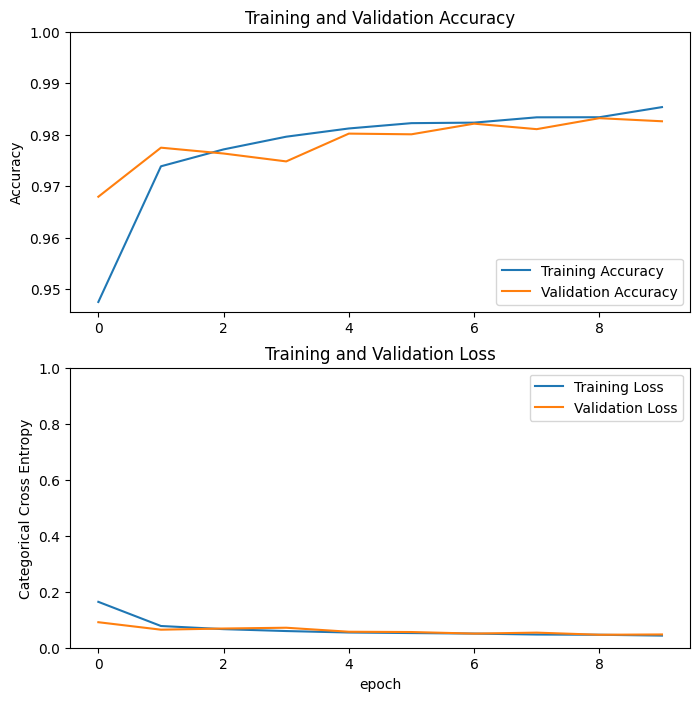

In [18]:
# Plot learning curves for training and validation data

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 6) Confusion matrix & classification performance

In [19]:
# Retrieve a batch of images from the validation set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)

# Formatting
y_true = np.argmax(label_batch, axis=1)
y_pred = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


W0000 00:00:1717505460.322400      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [20]:
#Confution Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('----------------')
print('Classification Report')
target_names = validation_dataset.class_names
print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix
[[7 0 0 0 1]
 [0 4 0 0 0]
 [0 0 6 0 0]
 [0 1 0 7 0]
 [0 0 0 0 6]]
----------------
Classification Report
              precision    recall  f1-score   support

     Arborio       1.00      0.88      0.93         8
     Basmati       0.80      1.00      0.89         4
      Ipsala       1.00      1.00      1.00         6
     Jasmine       1.00      0.88      0.93         8
   Karacadag       0.86      1.00      0.92         6

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32



### 7) Examples of correct and incorrect classification

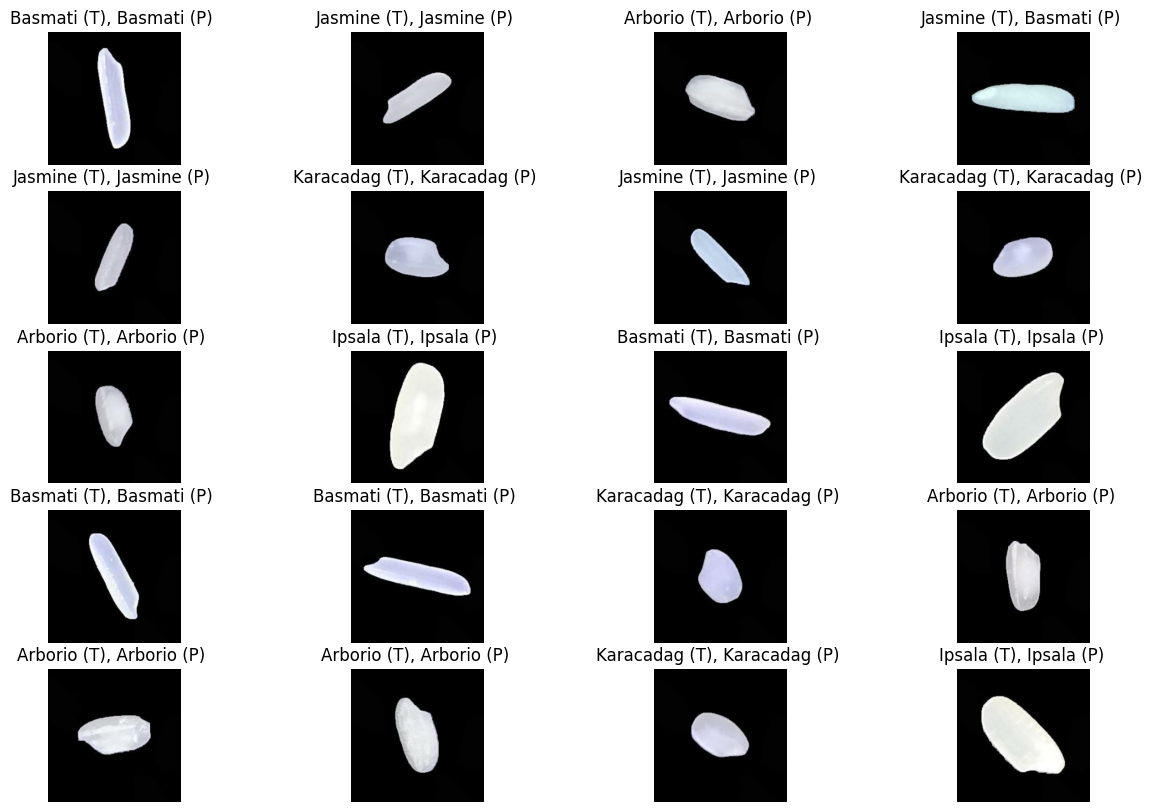

In [21]:
plt.figure(figsize=(15, 10))
for images, labels in validation_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ind = np.where(labels[i] == 1)[0][0]
        y_pred_ind = y_pred[i]
        plt.title(class_names[ind] + " (T), " + class_names[y_pred_ind] + " (P) ")
        plt.axis("off")

Codes are adapted from various sources: 
    
    - https://www.tensorflow.org/tutorials/images/transfer_learning